In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve, brier_score_loss
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import sys

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [ ]:
RANDOM_STATE = 42
N_SPLITS = 10
EPOCHS = 36
BATCH_SIZE = 64
VERBOSE = 1
CSV_PATH = "data/WA_Fn-UseC_-Telco-Customer-Churn.csv"

In [ ]:
df = pd.read_csv(CSV_PATH)

print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# ---- Basic Overview ----
print(df.info())
print("\nSummary Statistics (numeric):\n", df.describe())
print("\nUnique values per column:\n", df.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


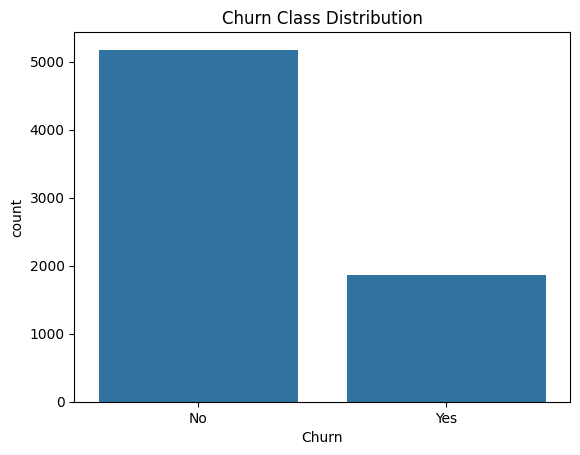

In [ ]:
# ---- Target Balance ----
sns.countplot(x='Churn', data=df)
plt.title("Churn Class Distribution")
plt.show()

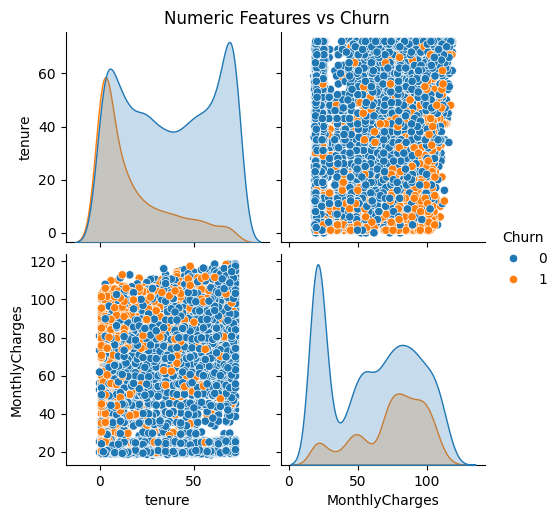

In [ ]:
# ---- Numeric Relationships ----
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
sns.pairplot(df[numeric_cols + ['Churn']].assign(Churn=df['Churn'].map({'No':0,'Yes':1})), hue='Churn')
plt.suptitle("Numeric Features vs Churn", y=1.02)
plt.show()

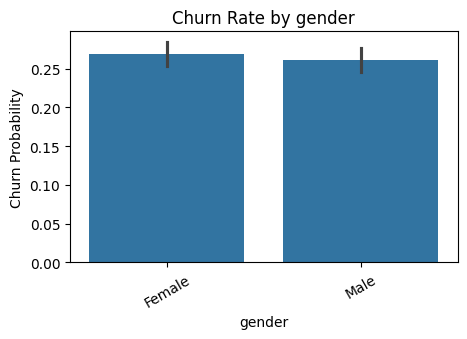

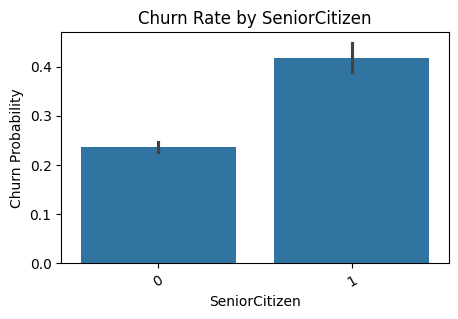

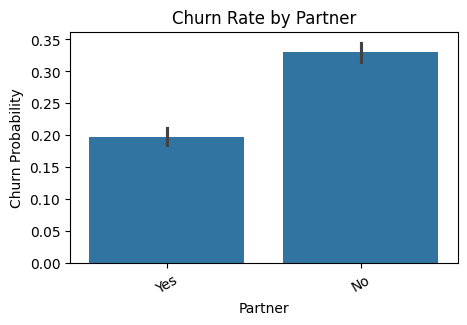

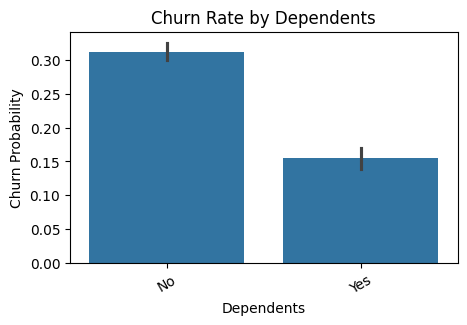

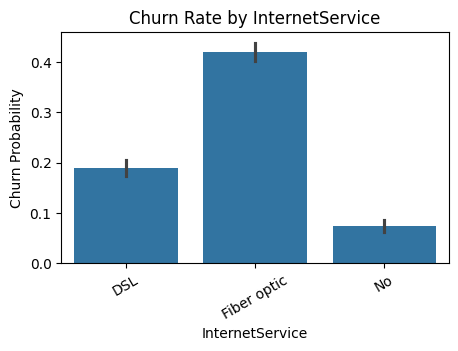

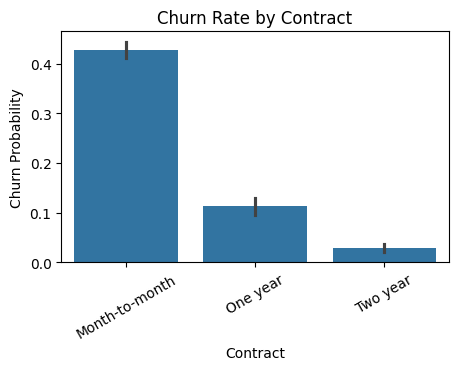

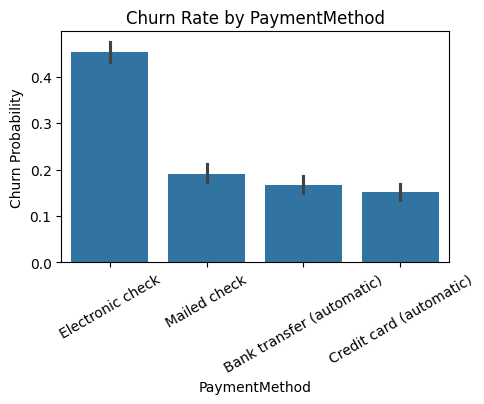

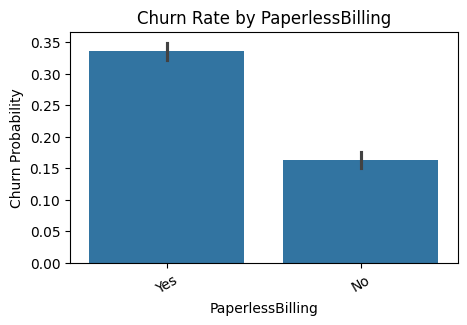

In [ ]:
# ---- Categorical Feature Impact ----
cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
            'Contract', 'PaymentMethod', 'PaperlessBilling']

for col in cat_cols:
    plt.figure(figsize=(5,3))
    sns.barplot(x=col, y=df['Churn'].map({'No':0,'Yes':1}), data=df, estimator='mean')
    plt.title(f"Churn Rate by {col}")
    plt.ylabel("Churn Probability")
    plt.xticks(rotation=30)
    plt.show()

In [ ]:
# -------------------------
# 1) LOAD DATA
# -------------------------
df = pd.read_csv(CSV_PATH)

# Clean & target mapping
# - Drop customerID (identifier)
# - Coerce TotalCharges to numeric (it contains blanks in raw file)
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Target: Churn -> {No:0, Yes:1}
assert 'Churn' in df.columns, "Target column 'Churn' not found."
y = df['Churn'].astype(str).str.strip().str.lower().map({'no':0, 'yes':1}).astype(int)
X = df.drop(columns=['Churn']).copy()

print("Columns:", list(df.columns))
print(f"X shape: {X.shape} | y positive rate (churn=1): {y.mean():.3f}")

Columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
X shape: (7043, 19) | y positive rate (churn=1): 0.265


In [ ]:
# -------------------------
# 2) PREPROCESSING
#    OneHot for categoricals, Standardize numerics
# -------------------------

# Drop identifier
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

# Coerce TotalCharges to numeric (it has blanks), filled with median
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Target to {No:0, Yes:1}
assert 'Churn' in df.columns
y = df['Churn'].astype(str).str.strip().str.lower().map({'no':0, 'yes':1}).astype(int)
X = df.drop(columns=['Churn']).copy()

print("Shapes:", X.shape, y.shape)
print("Positive rate (churn=1):", y.mean())
print("\nNull counts in X:\n", X.isna().sum().sort_values(ascending=False).head(10))
print("\nDtypes:\n", X.dtypes.head(20))


Shapes: (7043, 19) (7043,)
Positive rate (churn=1): 0.2653698707936959

Null counts in X:
 gender             0
SeniorCitizen      0
Partner            0
Dependents         0
tenure             0
PhoneService       0
MultipleLines      0
InternetService    0
OnlineSecurity     0
OnlineBackup       0
dtype: int64

Dtypes:
 gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object


Encoded feature matrix shape: (7043, 45)
Example columns: ['num__SeniorCitizen', 'num__tenure', 'num__MonthlyCharges', 'num__TotalCharges', 'cat__gender_Female', 'cat__gender_Male', 'cat__Partner_No', 'cat__Partner_Yes', 'cat__Dependents_No', 'cat__Dependents_Yes']


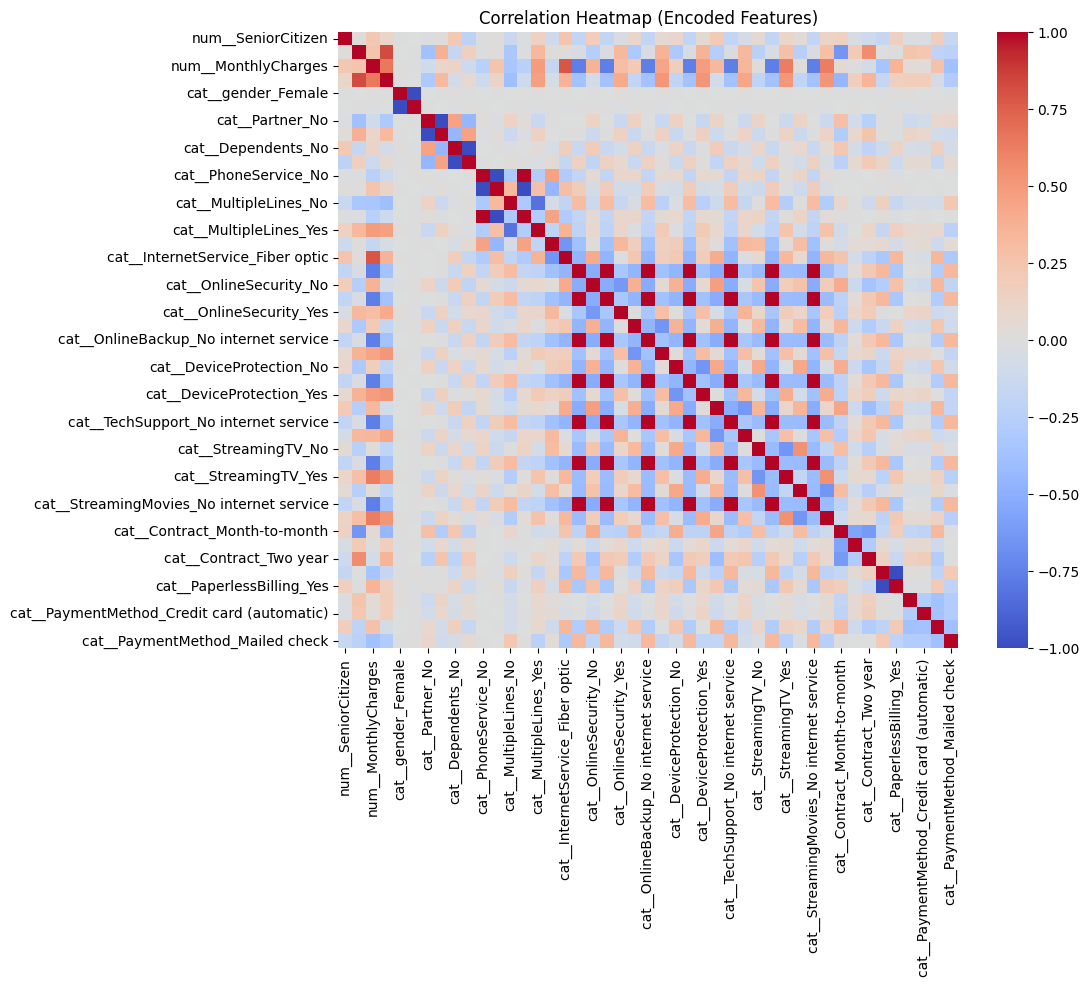

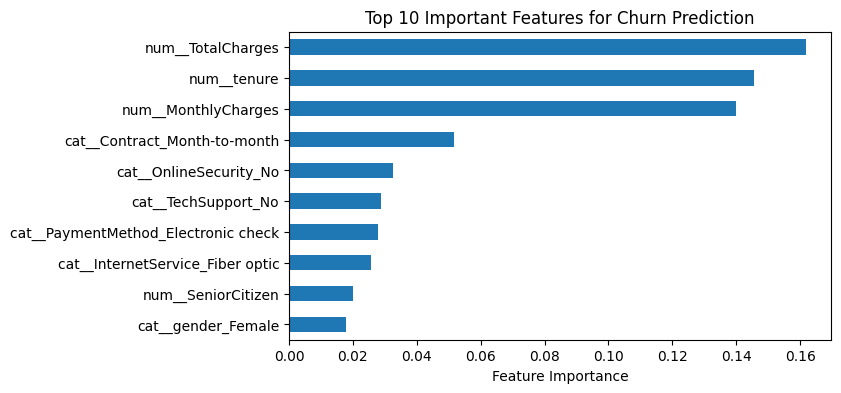

In [ ]:
# -----------------------------------
#  Post-preprocessing EDA
# -----------------------------------
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define column types
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

# Build the preprocessing transformer (same as your modeling code)
preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# 3Fit and transform
Xt = preprocess.fit_transform(X)
X_df = pd.DataFrame(Xt, columns=preprocess.get_feature_names_out())

print("Encoded feature matrix shape:", X_df.shape)
print("Example columns:", list(X_df.columns)[:10])

# Correlation Heatmap (for numeric relationships)
plt.figure(figsize=(10,8))
corr = X_df.corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Encoded Features)")
plt.show()

# Feature Importance via Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(Xt, y)
importances = pd.Series(rf.feature_importances_, index=preprocess.get_feature_names_out())

top10 = importances.sort_values(ascending=False).head(10)
plt.figure(figsize=(7,4))
top10.plot(kind='barh')
plt.title("Top 10 Important Features for Churn Prediction")
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# -------------------------
# 3) METRICS (manual)
# -------------------------
def compute_confusion(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return tp, tn, fp, fn

def safe_div(a, b):
    return a / b if b != 0 else 0.0

def metrics_from_counts(tp, tn, fp, fn):
    P = tp + fn
    N = tn + fp
    tpr = safe_div(tp, tp + fn)  # recall/sensitivity
    tnr = safe_div(tn, tn + fp)  # specificity
    fpr = safe_div(fp, fp + tn)
    fnr = safe_div(fn, fn + tp)
    acc = safe_div(tp + tn, P + N)
    bacc = (tpr + tnr) / 2.0
    prec = safe_div(tp, tp + fp)
    rec = tpr
    f1 = safe_div(2 * prec * rec, (prec + rec))
    err = 1 - acc
    # True Skill Statistic (TSS) = TPR - FPR
    tss = tpr - fpr
    # Heidke Skill Score (HSS) – common form using counts
    # HSS = 2*(TP*TN - FP*FN) / [(TP+FN)(FN+TN) + (TP+FP)(FP+TN)]
    denom = (tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)
    hss = safe_div(2 * (tp * tn - fp * fn), denom)
    return {
        'P': P, 'N': N,
        'TPR': tpr, 'TNR': tnr, 'FPR': fpr, 'FNR': fnr,
        'Accuracy': acc, 'BalancedAcc': bacc,
        'Precision': prec, 'Recall': rec, 'F1': f1, 'ErrorRate': err,
        'TSS': tss, 'HSS': hss
    }

def brier_scores(y_true, y_prob):
    # Brier Score
    bs = brier_score_loss(y_true, y_prob)
    # Climatology variance (reference) = mean((y - ybar)^2)
    ybar = np.mean(y_true)
    bs_ref = np.mean((y_true - ybar) ** 2)
    # Two versions (you can report both):
    bss = 1.0 - (bs / bs_ref)          # conventional skill score
    bss_alt = (bs / bs_ref)            # some lecture slides use this ratio
    return bs, bss, bss_alt

In [ ]:
# -------------------------
# 4) Keras Conv1D model for tabular
# -------------------------
def build_conv1d_model(n_features):
    inputs = keras.Input(shape=(n_features, 1))
    x = layers.Conv1D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='binary_crossentropy', metrics=[])
    return model

In [ ]:
# =========================
# 5) GLOBAL TUNE (3-fold) + OUTER 10-FOLD WITH FIXED PARAMS
# =========================
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from scipy.stats import randint, loguniform

# --- Identify columns once (global) ---
cat_cols_global = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
num_cols_global = [c for c in X.columns if c not in cat_cols_global]

def make_preprocess(cat_cols, num_cols):
    return ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
        ],
        remainder='drop'
    )

# -------- GLOBAL RANDOMIZED SEARCH (3-fold) --------
inner_cv_global = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
preprocess_global = make_preprocess(cat_cols_global, num_cols_global)

# RF pipeline + search
rf_pipe_global = Pipeline(steps=[
    ('prep', preprocess_global),
    ('clf', RandomForestClassifier(
        random_state=RANDOM_STATE, class_weight='balanced_subsample', n_jobs=-1
    ))
])
rf_param_dist = {
    'clf__n_estimators': randint(200, 700),
    'clf__max_depth': [None, 6, 8, 10, 12, 16, 20],
    'clf__min_samples_split': randint(2, 20),
    'clf__min_samples_leaf': randint(1, 10),
    'clf__max_features': ['sqrt', 'log2', None],
}
rf_search_global = RandomizedSearchCV(
    rf_pipe_global, rf_param_dist, n_iter=36,
    scoring='roc_auc', cv=inner_cv_global, n_jobs=-1,
    random_state=RANDOM_STATE, verbose=0
)
rf_search_global.fit(X, y)
rf_best_params_global = rf_search_global.best_params_
if VERBOSE:
    print("[GLOBAL] RF best params:", rf_best_params_global)

# SVM pipeline + search
svm_pipe_global = Pipeline(steps=[
    ('prep', preprocess_global),
    ('clf', SVC(kernel='rbf', probability=True, class_weight='balanced',
                random_state=RANDOM_STATE))
])
svm_param_dist = {
    'clf__C': loguniform(1e-2, 1e2),
    'clf__gamma': loguniform(1e-4, 1e0),
}
svm_search_global = RandomizedSearchCV(
    svm_pipe_global, svm_param_dist, n_iter=36,
    scoring='roc_auc', cv=inner_cv_global, n_jobs=-1,
    random_state=RANDOM_STATE, verbose=0
)
svm_search_global.fit(X, y)
svm_best_params_global = svm_search_global.best_params_
if VERBOSE:
    print("[GLOBAL] SVM best params:", svm_best_params_global)

# -------- OUTER 10-FOLD USING FIXED PARAMS --------
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

results_rf, results_svm, results_cnn = [], [], []
roc_rf, roc_svm, roc_cnn = [], [], []
auc_rf, auc_svm, auc_cnn = [], [], []

for fold, (tr, te) in enumerate(skf.split(X, y), 1):
    Xtr, Xte = X.iloc[tr].copy(), X.iloc[te].copy()
    ytr, yte = y.iloc[tr].values, y.iloc[te].values

    # Build a fresh preprocesser per fold (fit only on train)
    cat_cols = Xtr.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    num_cols = [c for c in Xtr.columns if c not in cat_cols]
    preprocess = make_preprocess(cat_cols, num_cols)

    # =======================
    # Random Forest (fixed params)
    # =======================
    # Rebuild pipeline with fixed classifier params (drop the 'clf__' prefix)
    rf_fixed = Pipeline(steps=[
        ('prep', preprocess),
        ('clf', RandomForestClassifier(
            random_state=RANDOM_STATE,
            class_weight='balanced_subsample',
            n_jobs=-1,
            **{k.replace('clf__',''): v for k, v in rf_best_params_global.items() if k.startswith('clf__')}
        ))
    ])
    rf_fixed.fit(Xtr, ytr)
    rf_prob = rf_fixed.predict_proba(Xte)[:, 1]
    rf_pred = (rf_prob >= 0.5).astype(int)
    tp, tn, fp, fn = compute_confusion(yte, rf_pred)
    m = metrics_from_counts(tp, tn, fp, fn)
    bs, bss, bss_alt = brier_scores(yte, rf_prob)
    auc = roc_auc_score(yte, rf_prob)
    fpr, tpr, _ = roc_curve(yte, rf_prob)
    results_rf.append({'Fold': fold, 'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn, **m,
                       'BS': bs, 'BSS': bss, 'BSS_alt': bss_alt, 'AUC': auc})
    roc_rf.append((fpr, tpr)); auc_rf.append(auc)

    # =======================
    # SVM (fixed params)
    # =======================
    svm_fixed = Pipeline(steps=[
        ('prep', preprocess),
        ('clf', SVC(kernel='rbf', probability=True, class_weight='balanced',
                    random_state=RANDOM_STATE,
                    **{k.replace('clf__',''): v for k, v in svm_best_params_global.items() if k.startswith('clf__')}))
    ])
    svm_fixed.fit(Xtr, ytr)
    svm_prob = svm_fixed.predict_proba(Xte)[:, 1]
    svm_pred = (svm_prob >= 0.5).astype(int)
    tp, tn, fp, fn = compute_confusion(yte, svm_pred)
    m = metrics_from_counts(tp, tn, fp, fn)
    bs, bss, bss_alt = brier_scores(yte, svm_prob)
    auc = roc_auc_score(yte, svm_prob)
    fpr, tpr, _ = roc_curve(yte, svm_prob)
    results_svm.append({'Fold': fold, 'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn, **m,
                        'BS': bs, 'BSS': bss, 'BSS_alt': bss_alt, 'AUC': auc})
    roc_svm.append((fpr, tpr)); auc_svm.append(auc)

    # =======================
    # Conv1D (no HPO; EarlyStopping)
    # =======================
    # For CNN we still need the encoded arrays
    Xt_tr = preprocess.fit_transform(Xtr)
    Xt_te = preprocess.transform(Xte)
    n_features = Xt_tr.shape[1]

    cnn = build_conv1d_model(n_features)
    Xtr_cnn = Xt_tr.reshape((-1, n_features, 1))
    Xte_cnn = Xt_te.reshape((-1, n_features, 1))
    pos = ytr.mean()
    class_weight = {0: 0.5/(1-pos+1e-12), 1: 0.5/(pos+1e-12)}

    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0)

    cnn.fit(
        Xtr_cnn, ytr,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=VERBOSE,
        class_weight=class_weight,
        validation_split=0.1,
        callbacks=[es, rlrop]
    )
    cnn_prob = cnn.predict(Xte_cnn, batch_size=BATCH_SIZE, verbose=0).ravel()
    cnn_pred = (cnn_prob >= 0.5).astype(int)
    tp, tn, fp, fn = compute_confusion(yte, cnn_pred)
    m = metrics_from_counts(tp, tn, fp, fn)
    bs, bss, bss_alt = brier_scores(yte, cnn_prob)
    auc = roc_auc_score(yte, cnn_prob)
    fpr, tpr, _ = roc_curve(yte, cnn_prob)
    results_cnn.append({'Fold': fold, 'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn, **m,
                        'BS': bs, 'BSS': bss, 'BSS_alt': bss_alt, 'AUC': auc})
    roc_cnn.append((fpr, tpr)); auc_cnn.append(auc)


[GLOBAL] RF best params: {'clf__max_depth': 20, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 9, 'clf__min_samples_split': 8, 'clf__n_estimators': 400}
[GLOBAL] SVM best params: {'clf__C': np.float64(21.368329072358772), 'clf__gamma': np.float64(0.0007068974950624604)}
Epoch 1/36
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.6939 - val_loss: 0.6901 - learning_rate: 0.0010
Epoch 2/36
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6778 - val_loss: 0.6883 - learning_rate: 0.0010
Epoch 3/36
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6682 - val_loss: 0.6780 - learning_rate: 0.0010
Epoch 4/36
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6370 - val_loss: 0.5724 - learning_rate: 0.0010
Epoch 5/36
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6066 - val_loss: 0.6272 - learning_rate: 0.0010
Epoch 6/36
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5813 - val_loss: 0.5547 - learning_rate: 0.0010
Epoch 7/36
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5659 - val

In [ ]:
# -------------------------
# 6) Tables and CSVs
# -------------------------
def build_table(results):
    df_ = pd.DataFrame(results)
    avg = df_.drop(columns=['Fold']).mean(numeric_only=True)
    avg_row = pd.DataFrame([{**{'Fold': 'Average'}, **avg.to_dict()}])
    return pd.concat([df_, avg_row], ignore_index=True)

tbl_rf  = build_table(results_rf)
tbl_svm = build_table(results_svm)
tbl_cnn = build_table(results_cnn)

print("\n=== Random Forest (per fold + average) ===")
display(tbl_rf.round(4))
print("\n=== SVM (per fold + average) ===")
display(tbl_svm.round(4))
print("\n=== Conv1D (per fold + average) ===")
display(tbl_cnn.round(4))

tbl_rf.to_csv("rf_results_10fold.csv", index=False)
tbl_svm.to_csv("svm_results_10fold.csv", index=False)
tbl_cnn.to_csv("conv1d_results_10fold.csv", index=False)
print("\nSaved: rf_results_10fold.csv, svm_results_10fold.csv, conv1d_results_10fold.csv")


=== Random Forest (per fold + average) ===


,Fold,TP,TN,FP,FN,P,N,TPR,TNR,FPR,...,Precision,Recall,F1,ErrorRate,TSS,HSS,BS,BSS,BSS_alt,AUC
0,1,146.0,402.0,116.0,41.0,187.0,518.0,0.7807,0.7761,0.2239,...,0.5573,0.7807,0.6503,0.2227,0.5568,0.4936,0.1515,0.2227,0.7773,0.8589
1,2,144.0,399.0,119.0,43.0,187.0,518.0,0.7701,0.7703,0.2297,...,0.5475,0.7701,0.6400,0.2298,0.5403,0.4782,0.1462,0.2499,0.7501,0.8651
2,3,147.0,388.0,130.0,40.0,187.0,518.0,0.7861,0.7490,0.2510,...,0.5307,0.7861,0.6336,0.2411,0.5351,0.4638,0.1578,0.1903,0.8097,0.8533
3,4,141.0,392.0,126.0,45.0,186.0,518.0,0.7581,0.7568,0.2432,...,0.5281,0.7581,0.6225,0.2429,0.5148,0.4518,0.1595,0.1797,0.8203,0.8362
4,5,148.0,406.0,111.0,39.0,187.0,517.0,0.7914,0.7853,0.2147,...,0.5714,0.7914,0.6637,0.2131,0.5767,0.5136,0.1458,0.2528,0.7472,0.8635
5,6,146.0,396.0,121.0,41.0,187.0,517.0,0.7807,0.7660,0.2340,...,0.5468,0.7807,0.6432,0.2301,0.5467,0.4810,0.1522,0.2199,0.7801,0.8574
6,7,138.0,377.0,140.0,49.0,187.0,517.0,0.7380,0.7292,0.2708,...,0.4964,0.7380,0.5935,0.2685,0.4672,0.4044,0.1809,0.0724,0.9276,0.7991
7,8,137.0,423.0,94.0,50.0,187.0,517.0,0.7326,0.8182,0.1818,...,0.5931,0.7326,0.6555,0.2045,0.5508,0.5123,0.1427,0.2687,0.7313,0.8562
8,9,147.0,381.0,136.0,40.0,187.0,517.0,0.7861,0.7369,0.2631,...,0.5194,0.7861,0.6255,0.2500,0.5230,0.4494,0.1603,0.1782,0.8218,0.8385
9,10,132.0,403.0,114.0,55.0,187.0,517.0,0.7059,0.7795,0.2205,...,0.5366,0.7059,0.6097,0.2401,0.4854,0.4410,0.1546,0.2073,0.7927,0.8381



=== SVM (per fold + average) ===


,Fold,TP,TN,FP,FN,P,N,TPR,TNR,FPR,...,Precision,Recall,F1,ErrorRate,TSS,HSS,BS,BSS,BSS_alt,AUC
0,1,119.0,449.0,69.0,68.0,187.0,518.0,0.6364,0.8668,0.1332,...,0.6330,0.6364,0.6347,0.1943,0.5032,0.5023,0.1389,0.2872,0.7128,0.8566
1,2,79.0,490.0,28.0,108.0,187.0,518.0,0.4225,0.9459,0.0541,...,0.7383,0.4225,0.5374,0.1929,0.3684,0.4267,0.1559,0.1999,0.8001,0.8465
2,3,123.0,447.0,71.0,64.0,187.0,518.0,0.6578,0.8629,0.1371,...,0.6340,0.6578,0.6457,0.1915,0.5207,0.5145,0.1470,0.2457,0.7543,0.8559
3,4,107.0,460.0,58.0,79.0,186.0,518.0,0.5753,0.8880,0.1120,...,0.6485,0.5753,0.6097,0.1946,0.4633,0.4807,0.1583,0.1857,0.8143,0.8291
4,5,0.0,517.0,0.0,187.0,187.0,517.0,0.0000,1.0000,0.0000,...,0.0000,0.0000,0.0000,0.2656,0.0000,0.0000,0.1527,0.2172,0.7828,0.8649
5,6,67.0,500.0,17.0,120.0,187.0,517.0,0.3583,0.9671,0.0329,...,0.7976,0.3583,0.4945,0.1946,0.3254,0.3948,0.1557,0.2020,0.7980,0.8503
6,7,104.0,428.0,89.0,83.0,187.0,517.0,0.5561,0.8279,0.1721,...,0.5389,0.5561,0.5474,0.2443,0.3840,0.3801,0.1562,0.1991,0.8009,0.8027
7,8,71.0,491.0,26.0,116.0,187.0,517.0,0.3797,0.9497,0.0503,...,0.7320,0.3797,0.5000,0.2017,0.3294,0.3892,0.1560,0.2001,0.7999,0.8371
8,9,103.0,472.0,45.0,84.0,187.0,517.0,0.5508,0.9130,0.0870,...,0.6959,0.5508,0.6149,0.1832,0.4638,0.4968,0.1581,0.1896,0.8104,0.8314
9,10,98.0,453.0,64.0,89.0,187.0,517.0,0.5241,0.8762,0.1238,...,0.6049,0.5241,0.5616,0.2173,0.4003,0.4181,0.1541,0.2102,0.7898,0.8327



=== Conv1D (per fold + average) ===


,Fold,TP,TN,FP,FN,P,N,TPR,TNR,FPR,...,Precision,Recall,F1,ErrorRate,TSS,HSS,BS,BSS,BSS_alt,AUC
0,1,131.0,417.0,101.0,56.0,187.0,518.0,0.7005,0.8050,0.1950,...,0.5647,0.7005,0.6253,0.2227,0.5056,0.4695,0.1655,0.1508,0.8492,0.8319
1,2,124.0,407.0,111.0,63.0,187.0,518.0,0.6631,0.7857,0.2143,...,0.5277,0.6631,0.5877,0.2468,0.4488,0.4148,0.1673,0.1418,0.8582,0.8195
2,3,128.0,405.0,113.0,59.0,187.0,518.0,0.6845,0.7819,0.2181,...,0.5311,0.6845,0.5981,0.2440,0.4663,0.4270,0.1865,0.0429,0.9571,0.8052
3,4,107.0,429.0,89.0,79.0,186.0,518.0,0.5753,0.8282,0.1718,...,0.5459,0.5753,0.5602,0.2386,0.4035,0.3966,0.1710,0.1203,0.8797,0.8026
4,5,121.0,443.0,74.0,66.0,187.0,517.0,0.6471,0.8569,0.1431,...,0.6205,0.6471,0.6335,0.1989,0.5039,0.4971,0.1792,0.0815,0.9185,0.8178
5,6,112.0,423.0,94.0,75.0,187.0,517.0,0.5989,0.8182,0.1818,...,0.5437,0.5989,0.5700,0.2401,0.4171,0.4040,0.1916,0.0180,0.9820,0.7743
6,7,120.0,376.0,141.0,67.0,187.0,517.0,0.6417,0.7273,0.2727,...,0.4598,0.6417,0.5357,0.2955,0.3690,0.3276,0.2001,-0.0259,1.0259,0.7596
7,8,98.0,457.0,60.0,89.0,187.0,517.0,0.5241,0.8839,0.1161,...,0.6203,0.5241,0.5681,0.2116,0.4080,0.4293,0.1750,0.1031,0.8969,0.7761
8,9,94.0,442.0,75.0,93.0,187.0,517.0,0.5027,0.8549,0.1451,...,0.5562,0.5027,0.5281,0.2386,0.3576,0.3689,0.1662,0.1477,0.8523,0.7890
9,10,105.0,428.0,89.0,82.0,187.0,517.0,0.5615,0.8279,0.1721,...,0.5412,0.5615,0.5512,0.2429,0.3894,0.3848,0.1741,0.1077,0.8923,0.8032



Saved: rf_results_10fold.csv, svm_results_10fold.csv, conv1d_results_10fold.csv


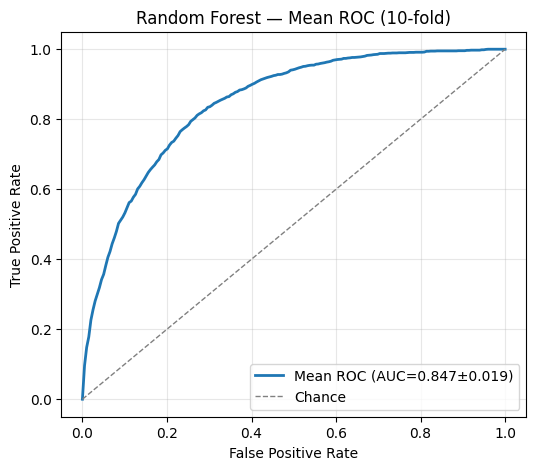

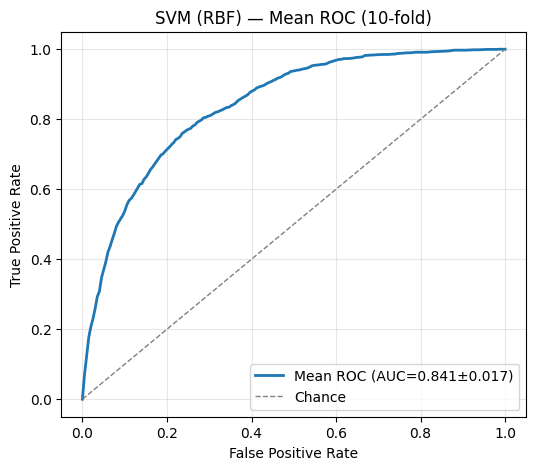

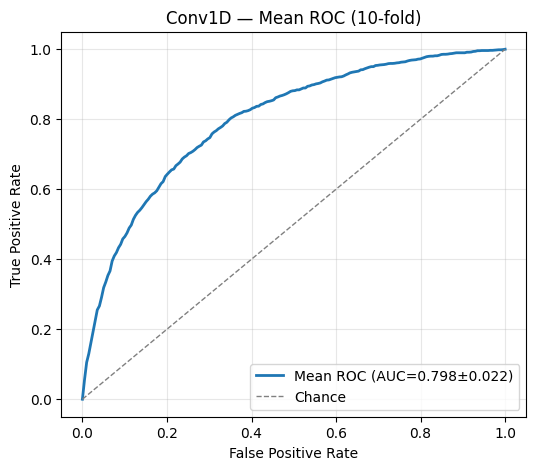

In [ ]:
# -------------------------
# 7) Mean ROC plots
# -------------------------
from numpy import interp

def plot_mean_roc(roc_list, auc_list, title):
    mean_fpr = np.linspace(0, 1, 200)
    tprs = []
    for fpr, tpr in roc_list:
        tpr_i = np.interp(mean_fpr, fpr, tpr)
        tpr_i[0] = 0.0
        tprs.append(tpr_i)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    auc_mean = np.mean(auc_list)
    auc_std = np.std(auc_list)

    plt.figure(figsize=(6,5))
    plt.plot(mean_fpr, mean_tpr, lw=2, label=f"Mean ROC (AUC={auc_mean:.3f}±{auc_std:.3f})")
    plt.plot([0,1],[0,1], linestyle='--', color='gray', lw=1, label='Chance')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

plot_mean_roc(roc_rf, auc_rf,  "Random Forest — Mean ROC (10-fold)")
plot_mean_roc(roc_svm, auc_svm, "SVM (RBF) — Mean ROC (10-fold)")
plot_mean_roc(roc_cnn, auc_cnn, "Conv1D — Mean ROC (10-fold)")

In [ ]:
# -------------------------
# 8) Summary (averages)
# -------------------------
def summary_row(df, name):
    row = df[df['Fold']=='Average'].copy()
    row.insert(0, 'Model', name)
    return row

summary = pd.concat([
    summary_row(tbl_rf,  'RandomForest'),
    summary_row(tbl_svm, 'SVM_RBF'),
    summary_row(tbl_cnn, 'Conv1D')
], ignore_index=True)

cols = ['Model','Accuracy','BalancedAcc','Precision','Recall','F1','TSS','HSS','BS','BSS','AUC']
print("\n=== Summary (averages across folds) ===")
display(summary[cols].round(4))
summary[cols].to_csv("summary_averages.csv", index=False)
print("Saved: summary_averages.csv")


=== Summary (averages across folds) ===


,Model,Accuracy,BalancedAcc,Precision,Recall,F1,TSS,HSS,BS,BSS,AUC
0,RandomForest,0.7657,0.7648,0.5427,0.7630,0.6338,0.5297,0.4689,0.1551,0.2042,0.8466
1,SVM_RBF,0.7920,0.6879,0.6023,0.4661,0.5146,0.3758,0.4003,0.1533,0.2137,0.8407
2,Conv1D,0.7620,0.7135,0.5511,0.6099,0.5758,0.4269,0.4120,0.1776,0.0888,0.7979


Saved: summary_averages.csv
